The idea of that notebook is to have a reproducible benchmark working with the masters version of `pysap` and `modopt` in April 2019. The benchmark will be on speed, for both sparkling and uniform random acquisition schemes, with a brain phantom, for decimated wavelets.

The benchmark will future the algorithms of the abstract submission for SPARS 2019.

Special attention must be taken for Condat. We might need to qualify the benchmark with non reproducible experiments where we set the norm of the linear operator. We also need to take care of the relaxation factor.

In [1]:
%load_ext autoreload
%autoreload 2

# Third party import
import matplotlib.pyplot as plt
import numpy as np
# from scipy.ndimage import imread
# from tqdm import tqdm_notebook

# Package import
from modopt.math.metrics import ssim
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_locations_to_mask, gridded_inverse_fourier_transform_nd
from mri.operators import NonCartesianFFT, WaveletUD2
from mri.reconstructors import SelfCalibrationReconstructor, SingleChannelReconstructor
from modopt.opt.proximity import SparseThreshold, GroupLASSO
from modopt.opt.linear import Identity


/neurospin/optimed/KPooja/Environments/EPI_sparkling/lib/python3.8/site-packages/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "


#  Loading input data

/neurospin/optimed/KPooja/Environments/EPI_sparkling/lib/python3.8/site-packages/mri/operators/fourier/utils/processing.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


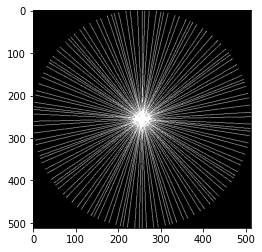

In [ ]:
# Loading input data
image = get_sample_data('2d-mri')

# Obtain MRI non-cartesian mask
radial_mask = get_sample_data("mri-radial-samples")
kspace_loc = radial_mask.data
mask = pysap.Image(data=convert_locations_to_mask(kspace_loc, image.shape))
plt.imshow(mask, cmap='gray')

# Generate the kspace 
From the 2D brain slice and the acquistion mask, we generate the acquisition measurments, the observed kspace. We then reconstruct the zero order solution.

In [3]:
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=image.shape, implementation='gpuNUFFT')
kspace_obs = fourier_op.op(image.data)

Zero order solution

In [4]:
grid_space = np.linspace(-0.5, 0.5, num=image.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, kspace_obs,
                                                 tuple(grid2D), 'linear')
image_rec0 = pysap.Image(data=grid_soln)
# image_rec0.show()
base_ssim = ssim(image_rec0, image)
print('The Base SSIM is : ' + str(base_ssim))

The Base SSIM is : 0.6751899832626058


# FISTA optimization
We now want to refine the zero order solution using a FISTA optimization.

In [5]:
mu = 2 * 1e-7

In [6]:
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)
regularizer_op = SparseThreshold(Identity(), mu, thresh_type="soft")
# Setup Reconstructor
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 17.83871859605514
The lipschitz constraint is satisfied


In [7]:
def objective_cost(x):
    return data_fidelity(x) + sparsity(x)

def sparsity(x):
    return mu * np.sum(np.abs(x))

def data_fidelity(x):
    return 0.5 * np.linalg.norm(fourier_op.op(x) - kspace_obs)**2

In [8]:
def nrmse(x):
    return np.linalg.norm(x - image) / np.mean(image)

In [9]:
metrics_ = {
    "cost": {"metric": objective_cost, "mapping": {"z_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "nrmse": {"metric": nrmse, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
}

In [10]:
opt_results = {}

In [11]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=200,
    metrics=metrics_,
    metric_call_period=1,
)
image_rec = pysap.Image(data=np.abs(x_final))

 - mu:  2e-07
 - lipschitz constant:  17.83871859605514
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7ff438a69280> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (2621440,)
----------------------------------------
Starting optimization...


N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 200) |                        | Elapsed Time: 0:00:03 ETA:   0:12:35
  1% (2 of 200) |                        | Elapsed Time: 0:00:07 ETA:   0:12:27
  1% (3 of 200) |                        | Elapsed Time: 0:00:11 ETA:   0:12:24
  2% (4 of 200) |                        | Elapsed Time: 0:00:15 ETA:   0:12:24
  2% (5 of 200) |                        | Elapsed Time: 0:00:18 ETA:   0:12:18
  3% (6 of 200) |                        | Elapsed Time: 0:00:22 ETA:   0:12:14
  3% (7 of 200) |                        | Elapsed Time: 0:00:26 ETA:   0:12:14
  4% (8 of 200) |                        | Elapsed Time: 0:00:30 ETA:   0:12:06
  4% (9 of 200) |#                       | Elapsed Time: 0:00:34 ETA:   0:12:03
  5% (10 of 200) |#                      | Elapsed Time: 0:00:37 ETA:   0:12:04
  5% (11 of 200) |#                      | Elapsed Time: 0:00:41 ETA:   0:11:57
  6% (12 of 200) |#                     

 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  764.4706473259721  seconds
----------------------------------------


In [12]:
opt_results[mu] = {
        "nrmse": metrics['nrmse']['values'][-1],
        "cost": metrics['cost']['values'][-1],
    }
print(opt_results)

{2e-07: {'nrmse': 126.78825406515858, 'cost': 1.7942731471480834e-05}}


In [13]:
params = {
    r"FISTA-BT": ({}, "black"),
    r"FISTA-CD, $a = 20$": ({"a_cd": 20}, "blue"),    
    r"Rada-FISTA": (
        {"p_lazy": (1/30), "q_lazy": (1/10), "restart_strategy": "adaptive", "xi_restart": 0.96}, 
        "orange",
    ),
    r"greedy FISTA": (
        {"restart_strategy": "greedy", "xi_restart": 0.96, "s_greedy": 1.1}, 
        "violet",
    ),
}

res_param = {}
for param_name, (param, _) in (params.items()):
    x_final, costs, metrics = reconstructor.reconstruct(
        kspace_data=kspace_obs,
        optimization_alg='fista',
        num_iterations=200,
        metrics = metrics_,
        metric_call_period=1,
        **param,
    )
    res_param[param_name] = {
        "cost": np.array(metrics['cost']['values']),
        "nrmse": np.array(metrics['nrmse']['values']),
    }

 - mu:  2e-07
 - lipschitz constant:  17.83871859605514
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7ff438a69280> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (2621440,)
----------------------------------------
Starting optimization...


N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 200) |                        | Elapsed Time: 0:00:03 ETA:   0:12:38
  1% (2 of 200) |                        | Elapsed Time: 0:00:07 ETA:   0:12:32
  1% (3 of 200) |                        | Elapsed Time: 0:00:11 ETA:   0:12:28
  2% (4 of 200) |                        | Elapsed Time: 0:00:15 ETA:   0:12:19
  2% (5 of 200) |                        | Elapsed Time: 0:00:19 ETA:   0:12:25
  3% (6 of 200) |                        | Elapsed Time: 0:00:22 ETA:   0:12:24
  3% (7 of 200) |                        | Elapsed Time: 0:00:26 ETA:   0:12:22
  4% (8 of 200) |                        | Elapsed Time: 0:00:30 ETA:   0:12:19
  4% (9 of 200) |#                       | Elapsed Time: 0:00:34 ETA:   0:12:07
  5% (10 of 200) |#                      | Elapsed Time: 0:00:38 ETA:   0:12:04
  5% (11 of 200) |#                      | Elapsed Time: 0:00:42 ETA:   0:12:05
  6% (12 of 200) |#                     

 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  768.2212120889453  seconds
----------------------------------------
 - mu:  2e-07
 - lipschitz constant:  17.83871859605514
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7ff438a69280> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (2621440,)
----------------------------------------
Starting optimization...


N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 200) |                        | Elapsed Time: 0:00:03 ETA:   0:12:50
  1% (2 of 200) |                        | Elapsed Time: 0:00:07 ETA:   0:12:46
  1% (3 of 200) |                        | Elapsed Time: 0:00:11 ETA:   0:12:42
  2% (4 of 200) |                        | Elapsed Time: 0:00:15 ETA:   0:12:38
  2% (5 of 200) |                        | Elapsed Time: 0:00:19 ETA:   0:12:33
  3% (6 of 200) |                        | Elapsed Time: 0:00:23 ETA:   0:12:31
  3% (7 of 200) |                        | Elapsed Time: 0:00:27 ETA:   0:12:28
  4% (8 of 200) |                        | Elapsed Time: 0:00:30 ETA:   0:12:21
  4% (9 of 200) |#                       | Elapsed Time: 0:00:34 ETA:   0:12:21
  5% (10 of 200) |#                      | Elapsed Time: 0:00:38 ETA:   0:12:14
  5% (11 of 200) |#                      | Elapsed Time: 0:00:42 ETA:   0:12:12
  6% (12 of 200) |#                     

 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  791.435056471033  seconds
----------------------------------------
 - mu:  2e-07
 - lipschitz constant:  17.83871859605514
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7ff438a69280> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (2621440,)
----------------------------------------
Starting optimization...


N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 200) |                        | Elapsed Time: 0:00:03 ETA:   0:13:01
  1% (2 of 200) |                        | Elapsed Time: 0:00:07 ETA:   0:12:57
  1% (3 of 200) |                        | Elapsed Time: 0:00:11 ETA:   0:12:53
  2% (4 of 200) |                        | Elapsed Time: 0:00:15 ETA:   0:12:49
  2% (5 of 200) |                        | Elapsed Time: 0:00:19 ETA:   0:12:45
  3% (6 of 200) |                        | Elapsed Time: 0:00:23 ETA:   0:12:40
  3% (7 of 200) |                        | Elapsed Time: 0:00:27 ETA:   0:12:38
  4% (8 of 200) |                        | Elapsed Time: 0:00:31 ETA:   0:12:36
  4% (9 of 200) |#                       | Elapsed Time: 0:00:35 ETA:   0:12:29
  5% (10 of 200) |#                      | Elapsed Time: 0:00:39 ETA:   0:12:26
  5% (11 of 200) |#                      | Elapsed Time: 0:00:43 ETA:   0:12:22
  6% (12 of 200) |#                     

KeyboardInterrupt: 

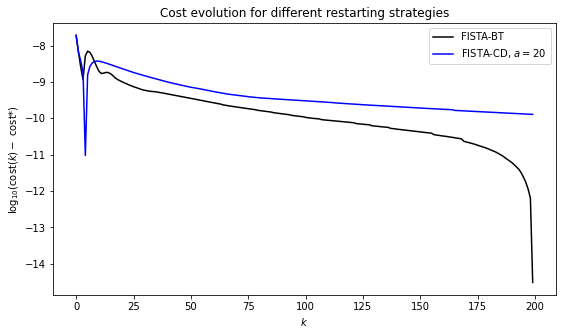

In [14]:
metric_name = "cost"
plt.figure(figsize=(9, 5))
for param_name, param_res in res_param.items():
    plt.plot(
        np.log10(np.abs(np.array(param_res[metric_name] - opt_results[mu][metric_name]))), 
        label=param_name, 
        color=params[param_name][1],
    )
plt.legend()
plt.title(r"Cost evolution for different restarting strategies")
plt.xlabel(r"$k$")
plt.ylabel(r"$\log_{10}($cost$(k) -$ cost$*)$")
plt.show()
plt.show(block = False)

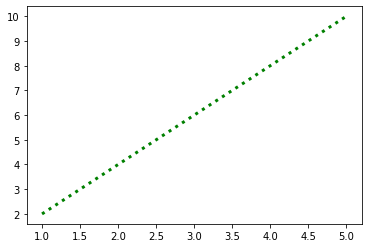

My First Matplotlib Program


In [ ]:

import matplotlib.pyplot as plt

# Define Data

x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]

# Plot

plt.plot(x, y, color='green', linewidth=3, linestyle='dotted')

# Display

plt.show(block=True)

# Print Statement

print('My First Matplotlib Program')
